In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(8, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, 4)

        nn.init.zeros_(self.dense1.bias)
        nn.init.zeros_(self.dense2.bias)
        nn.init.zeros_(self.dense3.bias)
        
        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense3.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.softmax(self.dense3(x), dim=1)
        return x

In [17]:
from sim import Reinforce
import gymnasium as gym

EPISODES = 100

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode='rgb_array')

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

reinforce = Reinforce(env, policy, optimizer, discount=0.99)
rewards, losses = reinforce.train(episodes=EPISODES, stats_interval=500)

New max of 1.991485883532306 in episode 15
New max of 59.6573076819289 in episode 24


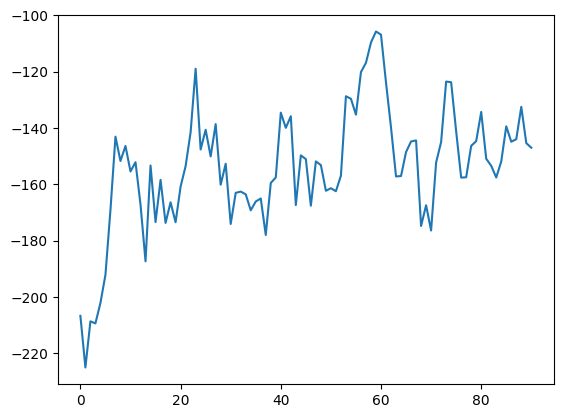

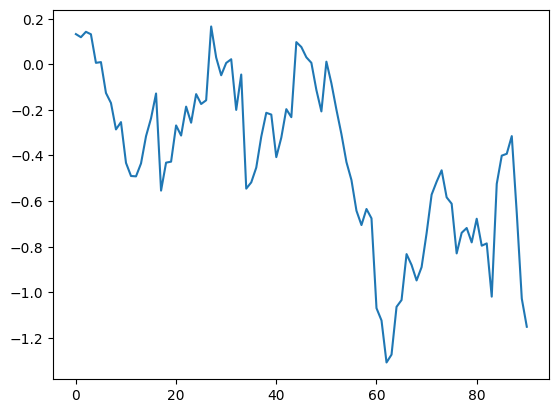

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))
plt.figure()
plt.plot(moving_average(losses, int(EPISODES/10)))

In [22]:
from matplotlib import animation
from IPython.display import HTML

def display_frames(frames, rewards, fps=30):
    fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(frames[0])

    reward_text = ax.text(10, 24, "", color="white", fontsize=12, weight='bold')

    def animate(i):
        im.set_array(frames[i])
        r = sum(rewards[:i+1])
        reward_text.set_text(f"Return: {r:.2f}")
        return [im, reward_text]
    
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000/fps)
    plt.close()
    return HTML(anim.to_jshtml())

display_frames(*reinforce.playback())

Playback Return: -839.6641715653931


In [23]:
reinforce.eval(episodes=5)

Average Return over 5 episodes: -711.9690704526447


In [ ]:
reinforce.save("models/cart_pole/REINFORCE_500")